# Exploring `SpatialData` objects using `napari`

Napari is a Python library for n-dimensional image visualisation, annotation, and analysis. With napari you can explore, modify and annotate 2D, 3D, and higher-dimensional data. Within the `SpatialData` ecosystem we provide the `napari-spatialdata` plugin that allows you do load `SpatialData` objects into `napari`.

⚠️ Adjust the variable below to the data path on your specific workstation.

In [1]:
# %load_ext jupyter_black

data_path = "../data/"

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import napari_spatialdata as nsd
import matplotlib.pyplot as plt
import pandas as pd

for p in [sd, sdp, nsd]:
    print(f"{p.__name__}: {p.__version__}")

sdata_visium = sd.read_zarr(data_path + "visium.zarr")
sdata_visium

/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04


spatialdata: 0.4.0
spatialdata_plot: 0.2.10
napari_spatialdata: 0.5.6


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/malbert/teaching/202505_Pasteur_Neubias/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day3/spatialdata/data/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes)
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_downscaled_hires', with elements:
        C

## Interactively explore and annotate the data

Explanation: Let's assume we want to focus our analysis on a specific region of the data. We can use napari to explore the data and annotate the region of interest.

To annotate region(s) of interest, first open some elements in the coordinate system common to all elements. Then add a new "Shapes" layer in napari and name it "ifi6_hotspots" (this name will be used later in the notebook). Draw 2-3 regions of interest using the "Add polygons lasso" tool.

Finally, to save the annotations in the spatialdata object, press Shift - E on the keyboard.

In [22]:
# uncomment to run napari and manually annotate the data
nsd.Interactive(sdata_visium)

2025-05-14 02:00:34.306 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-05-14 02:00:34.459 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-05-14 02:00:37.080 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-05-14 02:00:37.083 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.


## Inspect the shape we just created

In the elements list you will see a new element called "ifi6_hotspots". This is the shape we just created in napari.

In [6]:
sdata_visium

SpatialData object, with associated Zarr store: /Users/malbert/teaching/202505_Pasteur_Neubias/Pasteur-BioImage-Analysis-Course-2025/Analyst/Day3/spatialdata/data/visium.zarr
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 2000, 1744)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 600, 523)
├── Shapes
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (5756, 2) (2D shapes)
│     └── 'ifi6_hotspots': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (5756, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes), ifi6_hotspots (Shapes)
    ▸ 'CytAss

INFO     Rasterizing image for faster rendering.                                                                   


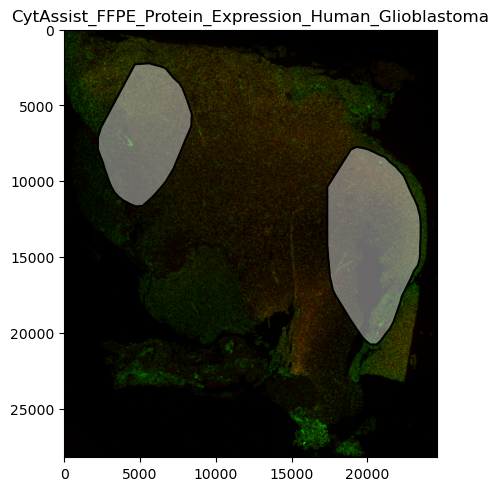

In [8]:
(
    sdata_visium.pl.render_images()
    .pl.render_shapes(
        "ifi6_hotspots",
        outline_alpha=1,
        contour_px=300,
        # method="matplotlib",
        fill_alpha=0.5,
    )
    .pl.show("CytAssist_FFPE_Protein_Expression_Human_Glioblastoma")
)

## Use the annotated shape to extract a subpopulation

In [9]:
from spatialdata import polygon_query

polygon = sdata_visium["ifi6_hotspots"].geometry.iloc[0]
filtered_sdata = polygon_query(
    sdata_visium, polygon=polygon, target_coordinate_system="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma"
)
filtered_sdata

SpatialData object
├── Images
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image': DataArray[cyx] (3, 670, 439)
│     └── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image': DataArray[cyx] (3, 201, 132)
├── Shapes
│     ├── 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma': GeoDataFrame shape: (521, 2) (2D shapes)
│     └── 'ifi6_hotspots': GeoDataFrame shape: (1, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (521, 18085)
with coordinate systems:
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_lowres_image (Images), CytAssist_FFPE_Protein_Expression_Human_Glioblastoma (Shapes), ifi6_hotspots (Shapes)
    ▸ 'CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_downscaled_hires', with elements:
        CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_hires_image (Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005319149..1.0].
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006024096..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013605442..1.2176871].
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_

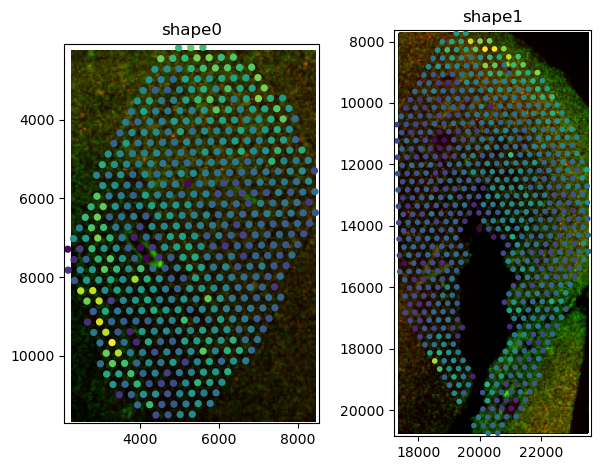

In [15]:
from spatialdata import polygon_query

fig, axs = plt.subplots(1, 2)

idx_in_selection = []

for shape in range(2):

    polygon = sdata_visium["ifi6_hotspots"].geometry.iloc[shape]
    filtered_sdata = polygon_query(
        sdata_visium, polygon=polygon,
        target_coordinate_system="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma"
    )
    filtered_sdata.pl.render_images().pl.render_shapes(
        element="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma",
        color="MT-CO2",
    ).pl.show("CytAssist_FFPE_Protein_Expression_Human_Glioblastoma",
    ax=axs[shape], colorbar=False, title=f"shape{shape}")

    # store names of spots within our 3 selections
    idx_in_selection.extend(filtered_sdata.tables["table"].obs.index.tolist())

plt.tight_layout()

## Use the subpopulation to annotate the original data

In [16]:
idx_in_selection[:3]

['AACACCATTCGCATAC-1', 'AACATAGGTTCCGCAC-1', 'AACGCCGGTAGAGGAT-1']

In [17]:
sdata_visium.tables["table"].obs["annotation"] = ""

sdata_visium.tables["table"].obs.loc[idx_in_selection, "annotation"] = "IFI6 Hotspot"

INFO     Rasterizing image for faster rendering.                                                                   


/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `CytAssist_FFPE_Protein_Expression_Human_Glioblastoma` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata_plot/pl/basic.py:936: UserWarning: Converting copy of 'annotation' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/Users/malbert/miniconda3/envs/day3/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:775: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a futur

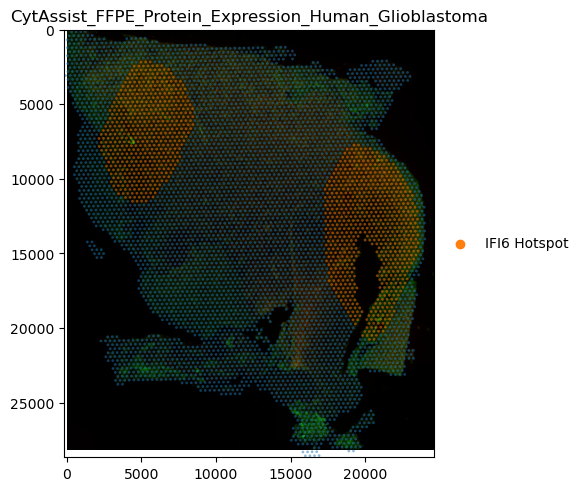

In [21]:
sdata_visium.pl.render_images().pl.render_shapes(
    element="CytAssist_FFPE_Protein_Expression_Human_Glioblastoma",
    color="annotation",
    fill_alpha=0.5,
).pl.show("CytAssist_FFPE_Protein_Expression_Human_Glioblastoma")